In [4]:
import os
import sys
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from osgeo import gdal, osr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
country = 'India'

admin_folder = Path(r'/Users/ipshitakarmakar/Dropbox (MIT)/ClimateFutures/Era5_clip/AOI/')
output_folder = Path(r'/Users/ipshitakarmakar/Dropbox (MIT)/ClimateFutures/Era5_clip/Output')
input_raster = Path(r'/Users/ipshitakarmakar/Dropbox (MIT)/ClimateFutures/Era5_clip/Raster/EuropeanAsia_Ta_SVCMsp_2020TMIN_150.tif')
city = ['Mumbai']
prepend_file_text = '2023_era5'


In [7]:


def clipdata_era(admin_folder, input_raster, output_folder, city):
    for file in os.listdir(admin_folder):
        if file.endswith(".shp"):
            print(f"Processing {file}")

            # Read shapefile
            shapefile_path = os.path.join(admin_folder, file)
            features = gpd.read_file(shapefile_path)
            print(f"Admin file CRS: {features.crs}")

            # Check if the geometries are valid
            if not all(features.is_valid):
                print("Invalid geometries found in shapefile. Attempting to fix...")
                features = features.buffer(0)
                if not all(features.is_valid):
                    print("Failed to fix geometries.")
                    continue

            # Convert to list of geometries
            geometries = features['geometry'].tolist()

            # Open raster file
            with rasterio.open(input_raster) as src:
                print(f"Raster file CRS: {src.crs}")

                # Check CRS alignment
                if features.crs != src.crs:
                    print("CRS mismatch between raster and shapefile. Aligning CRS...")
                    features = features.to_crs(src.crs)
                    geometries = features['geometry'].tolist()

                try:
                    # Clip raster with features
                    out_image, out_transform = mask(src, geometries, crop=True)
                except ValueError as e:
                    print(f"Error during clipping: {e}")
                    continue

                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                # Construct output file paths with city name in the filename
                prepend_file_text = f'2023_era5_f{city}_'
                output_file = os.path.join(output_folder, prepend_file_text + os.path.basename(input_raster))
                csv_output_file = os.path.join(output_folder, prepend_file_text + os.path.splitext(os.path.basename(input_raster))[0] + '.csv')

                # Save clipped raster to file
                with rasterio.open(output_file, "w", **out_meta) as dest:
                    dest.write(out_image)

                print(f"Saved clipped raster to {output_file}")

                # Convert clipped raster to CSV
                # Flatten the 2D array and generate coordinates
                array = out_image[0]  # Assuming a single band for simplicity
                rows, cols = np.indices(array.shape)
                flat_array = array.flatten()
                flat_rows = rows.flatten()
                flat_cols = cols.flatten()
                
                # Get the spatial coordinates
                x_coords, y_coords = rasterio.transform.xy(out_transform, flat_rows, flat_cols)
                
                # Create a DataFrame
                df = pd.DataFrame({
                    'x': x_coords,
                    'y': y_coords,
                    'value': flat_array
                })

                # Save DataFrame to CSV
                df.to_csv(csv_output_file, index=False)
                print(f"Saved clipped raster data to CSV {csv_output_file}")

                # Plot the clipped image
                plt.figure(figsize=(10, 10))
                plt.imshow(out_image[0], cmap='viridis')
                plt.colorbar()
                plt.title(f'Clipped Raster Image for {city}')
                plt.xlabel('Column Index')
                plt.ylabel('Row Index')
                plt.show()



Processing Mumbai.shp
Admin file CRS: EPSG:4326
Raster file CRS: PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS mismatch between raster and shapefile. Aligning CRS...
Saved clipped raster to /Users/ipshitakarmakar/Dropbox (MIT)/ClimateFutures/Era5_clip/Output/2023_era5_f2023_era5_EuropeanAsia_Ta_SVCMsp_2020TMIN_150.tif
Saved clipped raster data to CSV /Users/ipshitakarmakar/Dropbox (MIT)/ClimateFutures/Era5_clip/Output/2023_era5_f2023_era5_EuropeanAsia_Ta_SVCMsp_2020TMIN_150.csv


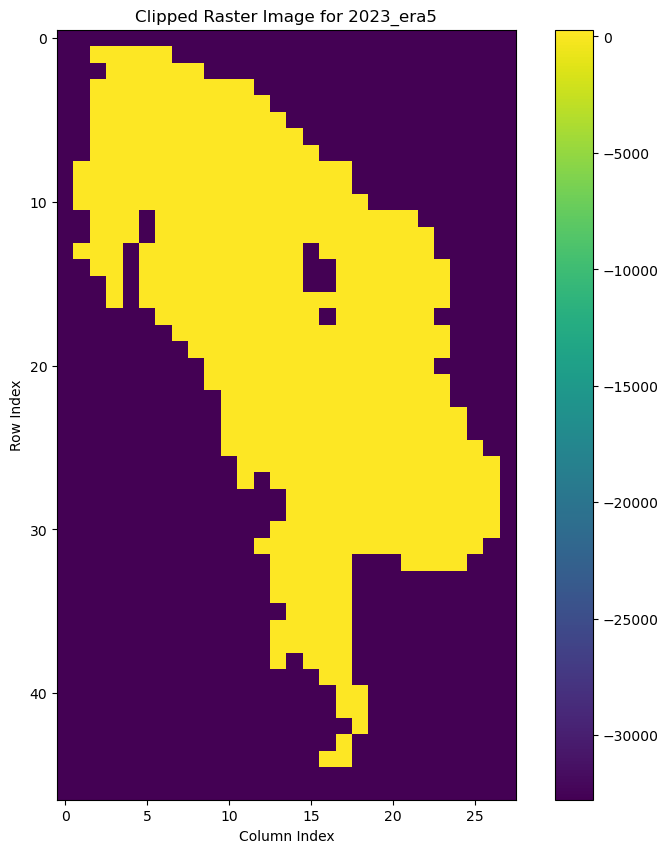

In [8]:
clipdata_era(admin_folder,input_raster,output_folder,prepend_file_text)